In [20]:
# Utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import math
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import torchvision

# sklearn
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class Transformer(nn.Module):

    def __init__(self, src_embed, tgt_embed, encoder, decoder, generator):
        super(Transformer, self).__init__()
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator


    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)


    def decode(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        return self.decoder(self.tgt_embed(tgt), encoder_out, tgt_mask, src_tgt_mask)


    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        src_tgt_mask = self.make_src_tgt_mask(src, tgt)
        encoder_out = self.encode(src, src_mask)
        decoder_out = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask)
        out = self.generator(decoder_out)
        #Transformer의 디코더는 입력을 처리하고 hidden state(많은 정보가 담긴 벡터)인 출력을 생성함
        #그렇기 때문에 이러한 hidden state는 단어를 예측하는데 유용하지 않음
        #그래서 이를 가져와서 점수 벡터에 매핑 하는 간단한 선형레이어임
        #여기서 각 점수는 어휘의 단어에 해당함
        out = F.log_softmax(out, dim=-1)
        #마지막에서 softmax의 차원을 -1로 설정해주는데 그 이유는 dimension인
        #len(vocab)에 대한 확률값을 구해야 하기 때문이다.
        return out, decoder_out


    def make_src_mask(self, src):
        pad_mask = self.make_pad_mask(src, src)
        return pad_mask


    def make_tgt_mask(self, tgt):
        pad_mask = self.make_pad_mask(tgt, tgt)
        seq_mask = self.make_subsequent_mask(tgt, tgt)
        mask = pad_mask & seq_mask
        return pad_mask & seq_mask


    def make_src_tgt_mask(self, src, tgt):
        pad_mask = self.make_pad_mask(tgt, src)
        return pad_mask


    def make_pad_mask(self, query, key, pad_idx=1):
        # query: (n_batch, query_seq_len)
        # key: (n_batch, key_seq_len)
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2)  # (n_batch, 1, 1, key_seq_len)
        key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len)

        query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3)  # (n_batch, 1, query_seq_len, 1)
        query_mask = query_mask.repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

        mask = key_mask & query_mask
        mask.requires_grad = False
        return mask


    def make_subsequent_mask(self, query, key):
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8') # lower triangle without diagonal
        #np.tril()을 이용해서 lower triangle을 생성함. query_seq_len과 key_seq_len이 모두 10일 때
        #대각선을 기준으로 하여 1과 0으로만 구성되어 있는 삼각형이 2개 생성됨
        mask = torch.tensor(tril, dtype=torch.bool, requires_grad=False, device=query.device)

        return mask


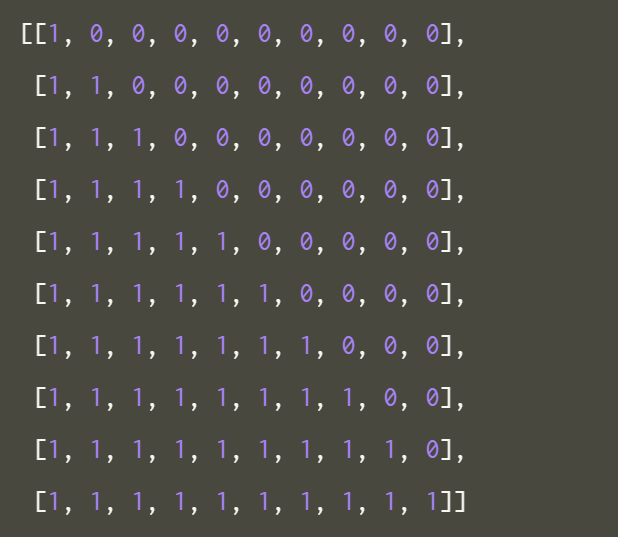

0번째 토큰의 경우 자기 자신밖에 볼 수 없으며, 1~n번째 토큰은 0으로 가려져있고.

---


1번째 토큰은 0~1번째 토큰밖에 보지 못합니다, 또한 나머지 2번째부터 n번째 토큰은 보지 못함.

In [3]:
class Encoder(nn.Module):

    def __init__(self, encoder_block, n_layer, norm):
        super(Encoder, self).__init__()
        self.n_layer = n_layer
        self.layers = nn.ModuleList([copy.deepcopy(encoder_block)
        for _ in range(self.n_layer)])
        self.norm = norm
#copy.deepcopy는 input으로 들어가는 개체의 전체 복사본을 만드는데 사용됨. 이는 input 개체에 대한
#참조를 복사하는 대신 개체의 새 인스턴스가 생성됨을 의미함.
#즉 주소를 참조해서 하는게 아니라 원본 자체를 복사하여, 복사본을 수정하더라도 주소값을 참조하지 않기
#때문에, 원본은 그대로 보존되고 복사본만 수정이 된다.
    def forward(self, src, src_mask):
        out = src
        for layer in self.layers:
            out = layer(out, src_mask)
        out = self.norm(out)
        return out

In [4]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff, norm, dr_rate=0):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.residual1 = ResidualConnectionLayer(copy.deepcopy(norm), dr_rate)
        self.position_ff = position_ff
        self.residual2 = ResidualConnectionLayer(copy.deepcopy(norm), dr_rate)


    def forward(self, src, src_mask):
        out = src
        out = self.residual1(out, lambda out: self.self_attention(query=out, key=out, value=out, mask=src_mask))
        out = self.residual2(out, self.position_ff)
        return out

In [6]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, h, qkv_fc, out_fc, dr_rate=0):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model)
        self.out_fc = out_fc              # (d_model, d_embed)
        self.dropout = nn.Dropout(p=dr_rate)


    def calculate_attention(self, query, key, value, mask):
        # query, key, value: (n_batch, h, seq_len, d_k)
        # mask: (n_batch, seq_len, seq_len)
        d_k = key.shape[-1]
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
        attention_prob = self.dropout(attention_prob)
        out = torch.matmul(attention_prob, value) # Attention score X V
        return out


    def forward(self, *args, query, key, value, mask=None):
        # query, key, value: (n_batch, seq_len, d_embed)
        # mask: (n_batch, seq_len, seq_len)
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)

        def transform(x, fc): # (n_batch, seq_len, d_embed)
            out = fc(x)       # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # (n_batch, seq_len, h, d_k)
            #view 메서드의 경우 multi head attention을 수행하기 위해 모델 차원을
            #multi head로 분리하도록 tensor를 재구성함.
            #view 메서드는 데이터를 변경하지 않고 tensor의 모양을 변경하는데 사용 됨.
            out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
            return out

        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc)       # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

        out = self.calculate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)
        return out


In [11]:
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, fc1, fc2, dr_rate=0):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1   # (d_embed, d_ff)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dr_rate)
        self.fc2 = fc2 # (d_ff, d_embed)


    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [12]:
class ResidualConnectionLayer(nn.Module):

    def __init__(self, norm, dr_rate=0):
        super(ResidualConnectionLayer, self).__init__()
        self.norm = norm
        self.dropout = nn.Dropout(p=dr_rate)


    def forward(self, x, sub_layer):
        out = x
        out = self.norm(out)
        out = sub_layer(out)
        out = self.dropout(out)
        out = out + x
        return out

In [15]:
class Decoder(nn.Module):

    def __init__(self, decoder_block, n_layer, norm):
        super(Decoder, self).__init__()
        self.n_layer = n_layer
        self.layers = nn.ModuleList([copy.deepcopy(decoder_block) for _ in range(self.n_layer)])
        self.norm = norm


    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        for layer in self.layers:
            out = layer(out, encoder_out, tgt_mask, src_tgt_mask)
        out = self.norm(out)
        return out

In [18]:



class DecoderBlock(nn.Module):

    def __init__(self, self_attention, cross_attention, position_ff, norm, dr_rate=0):
        super(DecoderBlock, self).__init__()
        self.self_attention = self_attention
        self.residual1 = ResidualConnectionLayer(copy.deepcopy(norm), dr_rate)
        self.cross_attention = cross_attention
        self.residual2 = ResidualConnectionLayer(copy.deepcopy(norm), dr_rate)
        self.position_ff = position_ff
        self.residual3 = ResidualConnectionLayer(copy.deepcopy(norm), dr_rate)


    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        out = self.residual1(out, lambda out: self.self_attention(query=out, key=out, value=out, mask=tgt_mask))
        out = self.residual2(out, lambda out: self.cross_attention(query=out, key=encoder_out, value=encoder_out, mask=src_tgt_mask))
        out = self.residual3(out, self.position_ff)
        return out

In [ ]:
class TransformerEmbedding(nn.Module):

    def __init__(self, token_embed, pos_embed, dr_rate=0):
        super(TransformerEmbedding, self).__init__()
        self.embedding = nn.Sequential(token_embed, pos_embed)
        self.dropout = nn.Dropout(p=dr_rate)


    def forward(self, x):
        out = x
        out = self.embedding(out)
        out = self.dropout(out)
        return out

In [ ]:
class TokenEmbedding(nn.Module):

    def __init__(self, d_embed, vocab_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.d_embed = d_embed


    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_embed)
        return out

In [19]:

class PositionalEncoding(nn.Module):

    def __init__(self, d_embed, max_len=256, device=torch.device("cpu")):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_embed)
        encoding.requires_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = encoding.unsqueeze(0).to(device)


    def forward(self, x):
        _, seq_len, _ = x.size()
        pos_embed = self.encoding[:, :seq_len, :]
        out = x + pos_embed
        return out

In [ ]:
def build_model(src_vocab_size,
                tgt_vocab_size,
                device=torch.device("cpu"),
                max_len = 256,
                d_embed = 512,
                n_layer = 6,
                d_model = 512,
                h = 8,
                d_ff = 2048,
                dr_rate = 0.1,
                norm_eps = 1e-5):
    import copy
    copy = copy.deepcopy

    src_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = src_vocab_size)
    tgt_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = tgt_vocab_size)
    pos_embed = PositionalEncoding(
                                   d_embed = d_embed,
                                   max_len = max_len,
                                   device = device)

    src_embed = TransformerEmbedding(
                                     token_embed = src_token_embed,
                                     pos_embed = copy(pos_embed),
                                     dr_rate = dr_rate)
    tgt_embed = TransformerEmbedding(
                                     token_embed = tgt_token_embed,
                                     pos_embed = copy(pos_embed),
                                     dr_rate = dr_rate)

    attention = MultiHeadAttentionLayer(
                                        d_model = d_model,
                                        h = h,
                                        qkv_fc = nn.Linear(d_embed, d_model),
                                        out_fc = nn.Linear(d_model, d_embed),
                                        dr_rate = dr_rate)
    position_ff = PositionWiseFeedForwardLayer(
                                               fc1 = nn.Linear(d_embed, d_ff),
                                               fc2 = nn.Linear(d_ff, d_embed),
                                               dr_rate = dr_rate)
    norm = nn.LayerNorm(d_embed, eps = norm_eps)

    encoder_block = EncoderBlock(
                                 self_attention = copy(attention),
                                 position_ff = copy(position_ff),
                                 norm = copy(norm),
                                 dr_rate = dr_rate)
    decoder_block = DecoderBlock(
                                 self_attention = copy(attention),
                                 cross_attention = copy(attention),
                                 position_ff = copy(position_ff),
                                 norm = copy(norm),
                                 dr_rate = dr_rate)

    encoder = Encoder(
                      encoder_block = encoder_block,
                      n_layer = n_layer,
                      norm = copy(norm))
    decoder = Decoder(
                      decoder_block = decoder_block,
                      n_layer = n_layer,
                      norm = copy(norm))
    generator = nn.Linear(d_model, tgt_vocab_size)

    model = Transformer(
                        src_embed = src_embed,
                        tgt_embed = tgt_embed,
                        encoder = encoder,
                        decoder = decoder,
                        generator = generator).to(device)
    model.device = device

    return model